### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
df=pd.read_csv('fraud.csv') # Load your dataset here

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Quick EDA (exploratory data analysis)

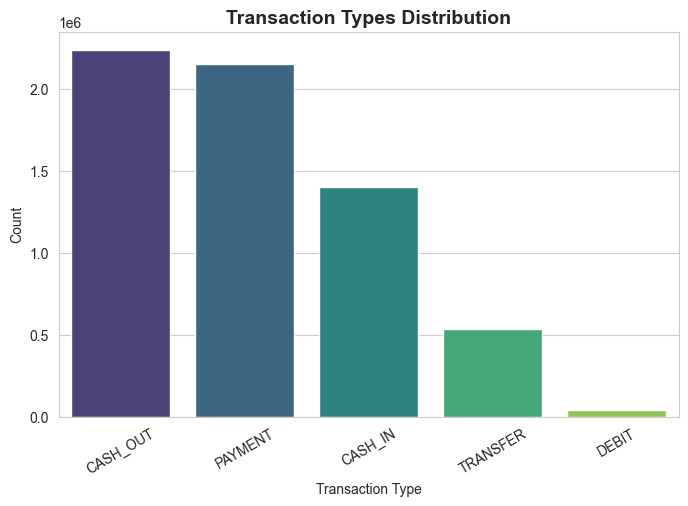

In [7]:
sns.set_style("whitegrid")
def plot_transaction_distribution(df):
    plt.figure(figsize=(8,5))
    ax = sns.countplot(
        data=df, 
        x='type', 
        palette="viridis", 
        order=df['type'].value_counts().index
    )
    ax.set_title("Transaction Types Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Transaction Type")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=30)
    plt.show()
plot_transaction_distribution(df)

This bar chart shows the frequency of different transaction types. The most common transactions are CASH_OUT and PAYMENT which both occur over two million times. CASH_IN is the next most frequent followed by TRANSFER and DEBIT as the least common. This indicates that most of the activity in this dataset involves money leaving or entering accounts.

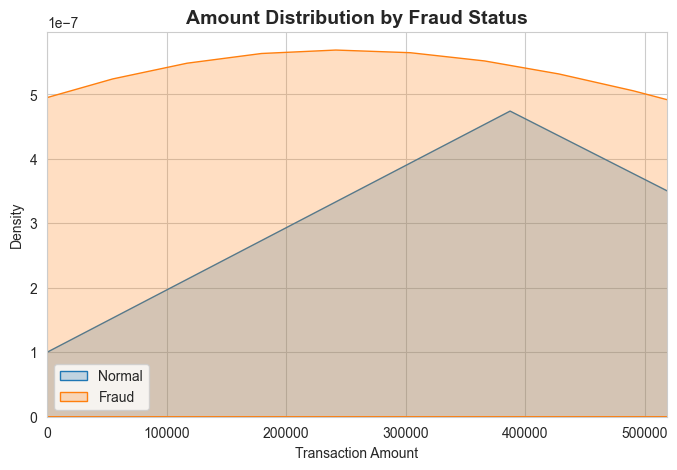

In [8]:
def plot_amount_distribution(df):
    plt.figure(figsize=(8,5))
    sns.kdeplot(df[df['isFraud']==0]['amount'], label='Normal', shade=True)
    sns.kdeplot(df[df['isFraud']==1]['amount'], label='Fraud', shade=True)
    plt.title("Amount Distribution by Fraud Status", fontsize=14, fontweight='bold')
    plt.xlabel("Transaction Amount")
    plt.ylabel("Density")
    plt.xlim(0, df['amount'].quantile(0.95))
    plt.legend()
    plt.show()
plot_amount_distribution(df)

This density plot compares the distribution of normal and fraudulent transaction amounts. The 'Normal' transactions (blue/gray area) are heavily concentrated at lower amounts, with a sharp peak. In contrast, 'Fraud' transactions (orange area) have a much broader and flatter distribution, indicating that fraud occurs across a wider range of transaction amounts. The density of fraudulent transactions is higher than normal transactions across this range.

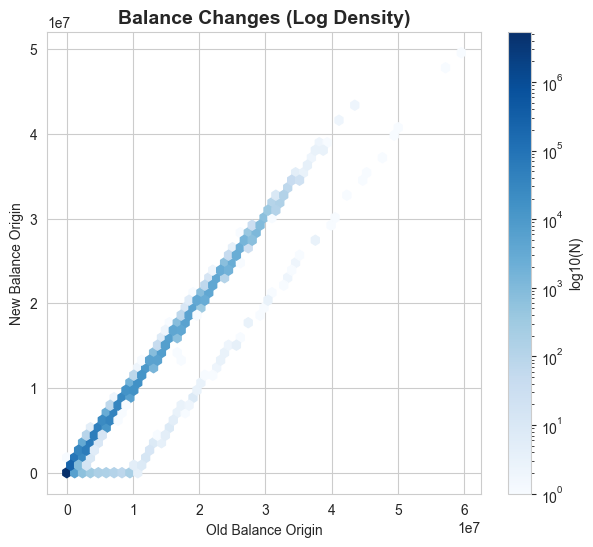

In [9]:
def plot_balance_changes(df):
    plt.figure(figsize=(7,6))
    hb = plt.hexbin(df['oldbalanceOrg'], df['newbalanceOrig'], gridsize=50, cmap='Blues', bins='log')
    plt.colorbar(hb, label="log10(N)")
    plt.title("Balance Changes (Log Density)", fontsize=14, fontweight='bold')
    plt.xlabel("Old Balance Origin")
    plt.ylabel("New Balance Origin")
    plt.show()
plot_balance_changes(df)

This hexbin plot visualizes how account balances change after a transaction. The x-axis is the old balance, and the y-axis is the new balance. The most prominent feature is the strong diagonal line, which shows that for the majority of transactions, the new balance is very close to the old balance, meaning the change was small. There is a cluster of points near the bottom left where the old balance is zero, which represents transactions where funds were added to accounts that previously had no money.

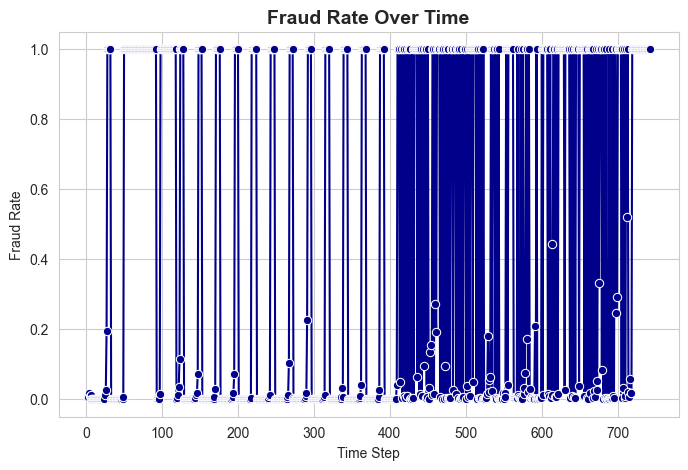

In [10]:
def plot_fraud_over_time(df):
    plt.figure(figsize=(8,5))
    fraud_over_time = df.groupby('step')['isFraud'].mean()
    sns.lineplot(x=fraud_over_time.index, y=fraud_over_time.values, color='darkblue', marker='o')
    plt.title("Fraud Rate Over Time", fontsize=14, fontweight='bold')
    plt.xlabel("Time Step")
    plt.ylabel("Fraud Rate")
    plt.show()
plot_fraud_over_time(df)

This line graph illustrates the proportion of fraudulent transactions at each time step. The plot shows an extremely erratic and volatile fraud rate, fluctuating sharply between 0% and 100%. This suggests that fraud is not a constant problem but rather occurs in concentrated bursts or time periods, followed by periods of little to no fraud. The large, solid blocks of high fraud rates show that in certain time steps, nearly all transactions were fraudulent.

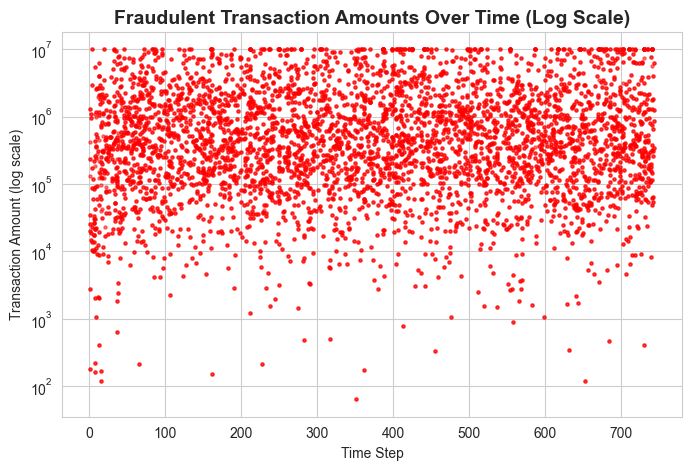

In [11]:
def plot_fraudulent_amounts_over_time(df):
    plt.figure(figsize=(8,5))
    fraud_data = df[df['isFraud']==1]
    plt.scatter(fraud_data['step'], fraud_data['amount'], alpha=0.5, s=5, color='red')
    plt.yscale('log')
    plt.title("Fraudulent Transaction Amounts Over Time (Log Scale)", fontsize=14, fontweight='bold')
    plt.xlabel("Time Step")
    plt.ylabel("Transaction Amount (log scale)")
    plt.show()
plot_fraudulent_amounts_over_time(df)

This scatter plot displays the amount of each fraudulent transaction over time. The y-axis is on a logarithmic scale. The plot shows that fraudulent transaction amounts are widely dispersed, ranging from small to very large values (from about 10 
2
  to 10 
7
 ). There is no clear pattern or trend suggesting that the amount of fraud increases or decreases as time progresses.

### Cleaning and preprocessing

In [12]:
df_features = df.copy()

In [13]:
df_features['balance_diff_orig'] = df_features['oldbalanceOrg'] - df_features['newbalanceOrig']
df_features['balance_diff_dest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest']


In [14]:
df_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_diff_orig,balance_diff_dest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,9839.64,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1864.28,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,181.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,181.00,-21182.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,339682.13,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,6311409.28,6311409.27
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,850002.52,0.00


In [15]:
df_features['error_balance_orig'] = df_features['newbalanceOrig'] + df_features['amount'] - df_features['oldbalanceOrg']
df_features['error_balance_dest'] = df_features['oldbalanceDest'] + df_features['amount'] - df_features['newbalanceDest']


In [16]:
le_type = LabelEncoder()
df_features['type_encoded'] = le_type.fit_transform(df_features['type'])

In [17]:
df_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_diff_orig,balance_diff_dest,error_balance_orig,error_balance_dest,type_encoded
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,9839.64,0.00,0.0,9.839640e+03,3
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1864.28,0.00,0.0,1.864280e+03,3
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,181.00,0.00,0.0,1.810000e+02,4
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,181.00,-21182.00,0.0,2.136300e+04,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,11668.14,0.00,0.0,1.166814e+04,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,339682.13,339682.13,0.0,0.000000e+00,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,6311409.28,0.00,0.0,6.311409e+06,4
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,6311409.28,6311409.27,0.0,1.000000e-02,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,850002.52,0.00,0.0,8.500025e+05,4


In [18]:
df_features['hour'] = df_features['step'] % 24

In [19]:
df_features['amount_category'] = pd.cut(df_features['amount'], 
                                       bins=[0, 1000, 10000, 100000, float('inf')], 
                                       labels=['small', 'medium', 'large', 'very_large'])
df_features['amount_category_encoded'] = LabelEncoder().fit_transform(df_features['amount_category'])


In [20]:
df_features['orig_zero_balance'] = (df_features['oldbalanceOrg'] == 0).astype(int)
df_features['dest_zero_balance'] = (df_features['oldbalanceDest'] == 0).astype(int)

In [21]:
df_features['log_amount'] = np.log1p(df_features['amount'])

In [22]:
df_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,balance_diff_dest,error_balance_orig,error_balance_dest,type_encoded,hour,amount_category,amount_category_encoded,orig_zero_balance,dest_zero_balance,log_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,...,0.00,0.0,9.839640e+03,3,1,medium,1,0,1,9.194276
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,...,0.00,0.0,1.864280e+03,3,1,medium,1,0,1,7.531166
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,...,0.00,0.0,1.810000e+02,4,1,small,2,0,1,5.204007
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,...,-21182.00,0.0,2.136300e+04,1,1,small,2,0,0,5.204007
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,...,0.00,0.0,1.166814e+04,3,1,large,0,0,1,9.364703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,...,339682.13,0.0,0.000000e+00,1,23,very_large,3,0,1,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,...,0.00,0.0,6.311409e+06,4,23,very_large,3,0,1,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,...,6311409.27,0.0,1.000000e-02,1,23,very_large,3,0,0,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,...,0.00,0.0,8.500025e+05,4,23,very_large,3,0,1,13.652996


### Define features and target

In [23]:
feature_columns = [
    'step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'balance_diff_orig', 'balance_diff_dest',
    'error_balance_orig', 'error_balance_dest', 'hour', 'amount_category_encoded',
    'orig_zero_balance', 'dest_zero_balance', 'log_amount'
]

X = df_features[feature_columns]
y = df_features['isFraud']

In [24]:
# Separate majority and minority classes
df_majority = df_features[df_features['isFraud']==0]
df_minority = df_features[df_features['isFraud']==1]

In [25]:
n_samples = min(100000, len(df_majority))
df_majority_sampled = df_majority.sample(n=n_samples, random_state=42)

# Use all minority samples
df_balanced = pd.concat([df_majority_sampled, df_minority])

In [26]:
# Prepare balanced dataset
X_balanced = df_balanced[feature_columns]
y_balanced = df_balanced['isFraud']

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Fraud distribution in balanced dataset: {y_balanced.value_counts()}")

Balanced dataset shape: (108213, 16)
Fraud distribution in balanced dataset: isFraud
0    100000
1      8213
Name: count, dtype: int64


### Train/test split

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model pipeline

In [28]:
results = {}
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred_proba)

results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_pred_proba,
    'auc_score': lr_auc
}

print(f"Logistic Regression AUC: {lr_auc:.4f}")

Logistic Regression AUC: 0.9767


In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)

results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'auc_score': rf_auc
}

print(f"Random Forest AUC: {rf_auc:.4f}")

Random Forest AUC: 0.9984


In [30]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test, gb_pred_proba)

results['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': gb_pred,
    'probabilities': gb_pred_proba,
    'auc_score': gb_auc
}

print(f"Gradient Boosting AUC: {gb_auc:.4f}")

Gradient Boosting AUC: 0.9994


### NEURAL NETWORK (Deep Learning with PyTorch)

In [31]:
# Define the neural network class
class FraudNet(nn.Module):
    def __init__(self, input_size):
        super(FraudNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [32]:
# Converting data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Creating  data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [33]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model = FraudNet(X_train_scaled.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [34]:
# Move tensors to device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Training loop
nn_model.train()
epochs = 50
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}')

Epoch [10/50], Loss: 0.0331
Epoch [20/50], Loss: 0.0265
Epoch [30/50], Loss: 0.0241
Epoch [40/50], Loss: 0.0222
Epoch [50/50], Loss: 0.0204


In [35]:
# Make predictions
nn_model.eval()
with torch.no_grad():
    nn_pred_proba = nn_model(X_test_tensor).cpu().numpy().flatten()
    nn_pred = (nn_pred_proba > 0.5).astype(int)

nn_auc = roc_auc_score(y_test, nn_pred_proba)

results['Neural Network'] = {
    'model': nn_model,
    'predictions': nn_pred,
    'probabilities': nn_pred_proba,
    'auc_score': nn_auc
}

print(f"Neural Network AUC: {nn_auc:.4f}")

Neural Network AUC: 0.9992


In [36]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC Score': [results[model]['auc_score'] for model in results.keys()]
})

comparison_df = comparison_df.sort_values('AUC Score', ascending=False)
print(comparison_df)


                 Model  AUC Score
2    Gradient Boosting   0.999369
3       Neural Network   0.999168
1        Random Forest   0.998425
0  Logistic Regression   0.976672


In [37]:
# Get best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best AUC Score: {best_model['auc_score']:.4f}")


Best Model: Gradient Boosting
Best AUC Score: 0.9994


In [38]:
print(f"\nDetailed evaluation of {best_model_name}:")
print("\nClassification Report:")
print(classification_report(y_test, best_model['predictions']))


Detailed evaluation of Gradient Boosting:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00     21643
   macro avg       1.00      1.00      1.00     21643
weighted avg       1.00      1.00      1.00     21643



Text(0.5, 25.722222222222214, 'Predicted')

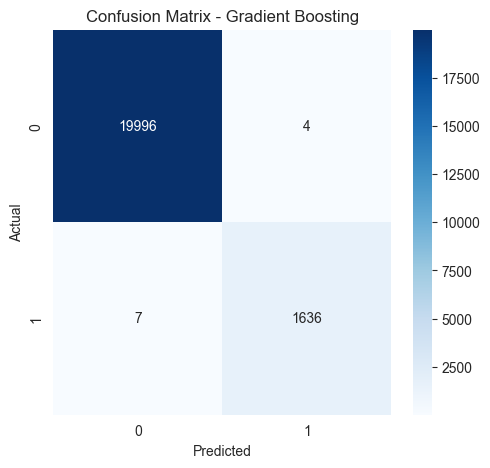

In [39]:
# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, best_model['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

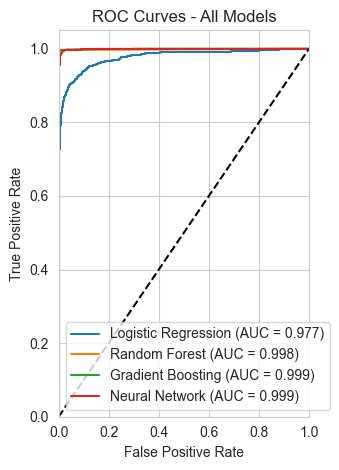

In [40]:
plt.subplot(1, 2, 2)
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['probabilities'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['auc_score']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()

plt.tight_layout()
plt.show()

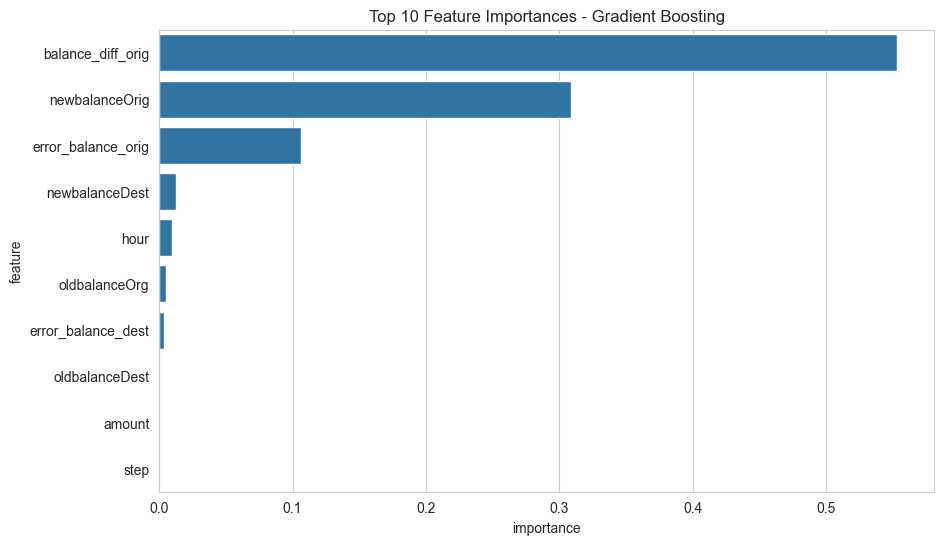

Top 10 Most Important Features:
               feature  importance
7    balance_diff_orig    0.553360
4       newbalanceOrig    0.308806
9   error_balance_orig    0.106678
6       newbalanceDest    0.012298
11                hour    0.009561
3        oldbalanceOrg    0.004838
10  error_balance_dest    0.003974
5       oldbalanceDest    0.000151
2               amount    0.000138
0                 step    0.000078


In [41]:
# Feature Importance (if available)
if hasattr(best_model['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))